In [16]:
import pandas
import matplotlib.pyplot as plt
import os
import h5py
import numpy as np
import gzip

# Plot config

In [17]:
# Using seaborn's style
plt.style.use('default')

font_config = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 11,
    "font.size": 11,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 11,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "axes.titlesize": 12,
}

# Set default color cycle
custom_cycle = ['#004791', '#4DA060', '#E86A58', '#FFBE00']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=custom_cycle)

plt.rcParams.update(font_config)

def set_size(width = 232, fraction=1, squeeze_height=1, subplots=(1, 1)):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'full':
        width_pt = 484
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1]) * squeeze_height

    return (fig_width_in, fig_height_in)

# Load data and helper functions

In [18]:
Ns = 10                 # number of stocks
Nt = 9                  # number of time steps
Nq = 2                 # Number of bits in the binary representation of the stock quantities
Ntot = Ns * Nt * Nq     # Total number of qubits/binary variables
K = 10                  # Budget constraint, maximum value is (2**Nq - 1)*Ns

# Map [n, t, q] to a single index i in [0, Ntot-1]
def tnq_to_index(t, n, q):
    i = 0
    for t_prime in range(Nt):
        for n_prime in range(Ns):
            for q_prime in range(Nq):
                if (n_prime, t_prime, q_prime) == (n, t, q):
                    return i
                i += 1
    return -1  # Should never reach here if inputs are valid

def index_to_tnq(i):
    q = i % Nq
    n = (i // Nq) % Ns
    t = (i // (Nq * Ns)) % Nt
    return t, n, q

# Convert binary solution to tnq format
def solution_to_tnq(solution):
    tnq_solution = np.zeros((Nt, Ns, Nq), dtype=int)
    for i, val in enumerate(solution):
        t, n, q = index_to_tnq(i)
        tnq_solution[t, n, q] = val
    return tnq_solution

In [19]:
path = f"../data/portfolio/instances/po_a0{Ns}_t{Nt + 1}_orig"

path_covariance = os.path.join(path, "covariance_matrices.txt.gz")
path_prices = os.path.join(path, "stock_prices.txt.gz")

skiplines = 9

# read
with gzip.open(path_covariance, 'rt') as f:
    covariance_matrices = []
    for line in f:
        row = [x for x in line.strip().split()]
        covariance_matrices.append(row)

with gzip.open(path_prices, 'rt') as f:
    stock_prices = []
    for line in f:
        stock_prices.append([x for x in line.strip().split()])

covariance_matrices = covariance_matrices[skiplines:]
stock_prices = stock_prices[skiplines:]

In [20]:
stock_to_index = {}
index_to_stock = {}

for i, price in enumerate(stock_prices):
    if int(price[0]) == 0:
        stock_to_index[price[1]] = i
        index_to_stock[i] = price[1]

stock_to_index

{'AAPL': 0,
 'NVDA': 1,
 'MSFT': 2,
 'GOOG': 3,
 'GOOGL': 4,
 'AMZN': 5,
 'META': 6,
 'TSLA': 7,
 'AVGO': 8,
 'WMT': 9}

In [21]:
prices = np.zeros((Nt + 1, Ns))
sigma = np.zeros((Nt + 1, Ns, Ns))

for row in stock_prices:
    t = int(row[0])
    stock_id = row[1]
    i = stock_to_index[stock_id]
    prices[t, i] = float(row[2])

for row in covariance_matrices:
    t = int(row[0])
    stock_id1 = row[1]
    stock_id2 = row[2]
    i = stock_to_index[stock_id1]
    j = stock_to_index[stock_id2]
    sigma[t, i, j] = float(row[3])
    sigma[t, j, i] = float(row[3])  # symmetric

# Drop first day of covariance matrices (no returns on day 0)
sigma = sigma[1:]

# Calculate log returns
mu = (prices[1:] - prices[:-1]) / prices[:-1]  # bare returns
mu = np.log(1 + mu)  # log returns

In [22]:
def decode_weights(x, K):
    """
    Decode binary representation into real-valued portfolio weights.
    x: ndarray of shape (Ns, Nt, Na, Nq)
    K: normalization constant (e.g., 2**Nq - 1)
    Returns w: (Ns, Nt, Na)
    """
    powers = 2 ** np.arange(x.shape[-1])  # shape (Nq,)
    return (x * powers).sum(axis=-1) / K  # sum over bit axis

def total_profit(x, returns, K, lam):
    """
    Compute total profit per optimization step, including transaction costs.

    Parameters
    ----------
    x : ndarray (Ns, Nt, Na, Nq)
        Binary portfolio variables.
    returns : ndarray (Nt, Na)
        Asset returns.
    K : float
        Normalization constant.
    lam : float
        Transaction cost parameter λ.

    Returns
    -------
    profit : ndarray (Ns,)
        Total profit per optimization step.
    """
    w = decode_weights(x, K)  # (Ns, Nt, Na)

    # Portfolio profit from returns
    profits_t = (w * returns[None, :, :]).sum(axis=-1)  # (Ns, Nt)
    gross_profit = profits_t.sum(axis=-1)               # (Ns,)

    # Transaction cost term λ * Σ_t (Δw_t)^2
    dw = np.diff(w, axis=1)                             # (Ns, Nt-1, Na)
    cost = lam * (dw**2).sum(axis=(1, 2))               # (Ns,)

    # Net profit
    net_profit = gross_profit - cost
    return net_profit


def sharpe_ratio(x, mu, sigma, K, risk_free=0.0):
    """
    Compute theoretical Sharpe ratio per optimization step using mean and covariance.

    Parameters
    ----------
    x : ndarray (Ns, Nt, Na, Nq)
        Binary portfolio variables.
    mu : ndarray (Nt, Na)
        Mean returns per asset and time.
    sigma : ndarray (Nt, Na, Na)
        Covariance matrices per time step.
    K : float
        Normalization constant for decoding.
    risk_free : float, optional
        Risk-free rate (default 0.0).

    Returns
    -------
    sharpe : ndarray (Ns,)
        Sharpe ratio per optimization step.
    """
    w = decode_weights(x, K)  # (Ns, Nt, Na)

    # Expected return per step: sum_t w_t · mu_t
    expected_return = np.einsum('stn,tn->s', w, mu)  # (Ns,)

    # Portfolio variance: sum_t w_t^T Σ_t w_t
    variance = np.einsum('stn,tnm,stm->s', w, sigma, w)  # (Ns,)

    # Compute Sharpe ratio
    sharpe = np.where(variance > 0, (expected_return - risk_free) / np.sqrt(variance), np.nan)
    return sharpe

# Plots

In [23]:
gurobi_sol = [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0]
tnq_gurobi = solution_to_tnq(gurobi_sol)
gurobi_value = -9.10104892705591

triangular, fiedler, chi=8: 0.005963639045012292 
triangular, fiedler, chi=16: 0.005003602535984197 
triangular, fiedler, chi=32: 0.0053141135522714045 
triangular, fiedler, chi=64: 0.005474515101718147 
triangular, fiedler, chi=128: 0.003824737863269978 
triangular, default, chi=8: 0.006864144759158086 
triangular, default, chi=16: 0.008438169195654321 
triangular, default, chi=32: 0.006255502549257663 
triangular, default, chi=64: 0.007844626717827707 
triangular, default, chi=128: 0.0037811516782355614 
triangular, shuffle, chi=8: 0.010646140757036848 
triangular, shuffle, chi=16: 0.010334719058374575 
triangular, shuffle, chi=32: 0.011373449592320228 
triangular, shuffle, chi=64: 0.01199377134136903 
triangular, shuffle, chi=128: 0.01017746601300773 
quadratic, fiedler, chi=8: 0.010140104877193079 
quadratic, fiedler, chi=16: 0.009236534568868748 
quadratic, fiedler, chi=32: 0.007202488196733858 
quadratic, fiedler, chi=64: 0.004619552866930943 
quadratic, fiedler, chi=128: 0.00540

/tmp/ipykernel_4184901/1932394451.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels([8, 16, 32, 64, 128])


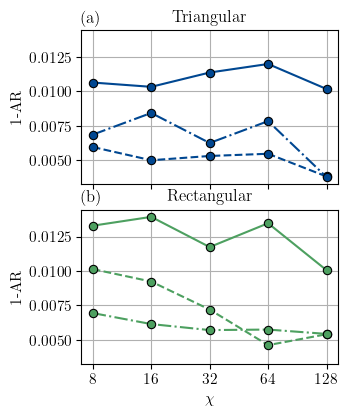

In [24]:
chi_list = [8, 16, 32, 64, 128]
from matplotlib.lines import Line2D
from matplotlib.ticker import ScalarFormatter

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True)

for row, architecture in enumerate(["triangular", "quadratic"]):
    for qubit_ordering in ["fiedler", "default", "shuffle"]:
        final_AR_list = np.zeros(len(chi_list))
        for i, chi in enumerate(chi_list):
            data_path = f"../results/portfolio/MPS_dtau10/ising_Ns10_Nt9_Nq2_K10_gamma1_zeta0.042_rho1.0_{architecture}_chi{chi}_{qubit_ordering}/results.h5"
            with h5py.File(data_path, "r") as data:
                samples = data["energy_samples"][:]
                runtime = data["runtime"][:]
                best_sample = samples.min(axis=1)
                avg_energy = samples.mean(axis=1)

            # Get the best overall sample, which would be the output
            best_sample = best_sample.min()
            #best_sample = best_sample[-1]
            final_AR = best_sample / gurobi_value
            final_AR_list[i] = final_AR

            # print the average and std of the final AR
            print(f"{architecture}, {qubit_ordering}, chi={chi}: {1-final_AR} ")

        if architecture == "quadratic":
            color = "C1"
        else:
            color = "C0"

        # Plot - / -- for fiedler, : for shuffle
        if qubit_ordering == "fiedler":
            linestyle = "--"
        elif qubit_ordering == "default":
            linestyle = "-."
        else:
            linestyle = "-"

        ax[row].plot( 
            1-final_AR_list,
            linestyle=linestyle,
            color=color,
            markeredgecolor="black",
            marker="o",
            markersize=6,
            markeredgewidth=.8,
            label =f"{qubit_ordering}"
        )
        ax[row].grid(True)

ax[1].set_xticklabels([8, 16, 32, 64, 128])
ax[1].set_xticks([0, 1, 2, 3, 4])

ax[1].set_xlabel(r"$\chi$")
ax[1].set_ylabel("1-AR")
ax[0].set_ylabel("1-AR")

ax[0].set_title("(a)", loc='left')
ax[0].set_title("Triangular", loc='center')

ax[1].set_title("(b)", loc='left')
ax[1].set_title("Rectangular", loc='center')

fig.set_size_inches(set_size(fraction=1, subplots=(2, 1)))
fig.set_dpi(100)
fig.tight_layout(pad=.01)

# # save as pdf
fig.savefig("paper_figures/qubit_ordering_portfolio.pdf", bbox_inches='tight')

# Final plots

In [ ]:
gurobi_sol = [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0]
gurobi_value = -9.103089743187352

0.004048069787052633
3.220369419388317 3.4205459419673185


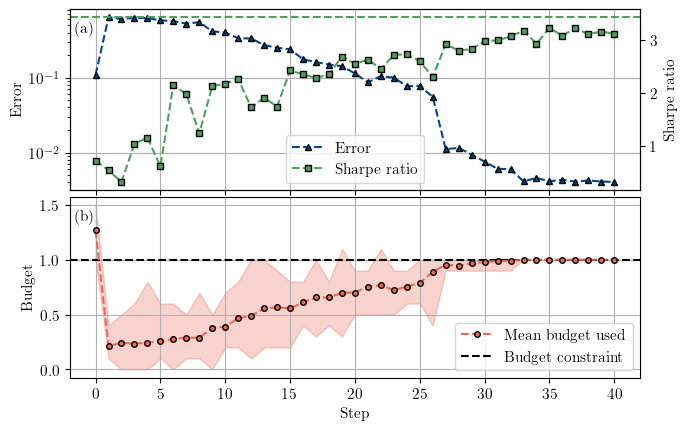

In [27]:
fig, axes = plt.subplots(2, 1, figsize=set_size(width = "full", fraction=1, subplots=(2, 1), squeeze_height=0.5), sharex=True)

# ----------------------------------------------------------------------------------
# Cost vs step
data_path = "../results/portfolio/MPS_dtau10/ising_Ns10_Nt9_Nq2_K10_gamma1_zeta0.042_rho1.0_triangular_chi128_fiedler/results.h5"

with h5py.File(data_path, "r") as data:
    samples = data["samples"][:]
    energy_samples = data["energy_samples"][:]
    
best_samples = samples[np.arange(samples.shape[0]), energy_samples.argmin(axis=1)]
tnq_solutions = np.array([solution_to_tnq(sample) for sample in best_samples])

best_energy = energy_samples.min(axis=1)
avg_energy = energy_samples.mean(axis=1)
print((1-best_energy/gurobi_value).min())
# best error


axes[0].semilogy(1-best_energy/gurobi_value, label="Error", marker = '^', linestyle="--", markeredgecolor="black", markersize=4)
#axes[0].semilogy(1-avg_energy/gurobi_value, label="Average energy / Gurobi")

#axes[0].set_xlabel("Step")
axes[0].set_ylabel("Error")
axes[0].grid()
axes[0].text(
    0.01, .85, "(a)",
    transform=axes[0].transAxes,
    va="bottom", ha="left", fontweight="bold"
)

ax2 = axes[0].twinx()

# Profit and Sharpe ratio vs step
sr = sharpe_ratio(tnq_solutions, mu, sigma, K)
sr_gurobi = sharpe_ratio(tnq_gurobi[None, :, :, :], mu, sigma, K)[0]
print(sr.max(), sr_gurobi)
profit = total_profit(tnq_solutions, mu, K, 0.042)
profit_gurobi = total_profit(tnq_gurobi[None, :, :, :], mu, K, 0.042)[0]

ax2.plot(sr, marker='s', linestyle="--", label="Sharpe ratio", color = "C1", markeredgecolor="black", markersize=4)
ax2.set_ylabel("Sharpe ratio")
ax2.set_xlabel("Step")

ax2.axhline(y=sr_gurobi, color='C1', linestyle='--')

# Add custom legend on ax
lines, labels = axes[0].get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
axes[0].legend(lines + lines2, labels + labels2, loc='lower center')

# Adhering to constraint
# ----------------------------------------------------------------------------------
min_budget = decode_weights(tnq_solutions, K).sum(axis=2).min(axis=1)
max_budget = decode_weights(tnq_solutions, K).sum(axis=2).max(axis=1)
mean_budget = decode_weights(tnq_solutions, K).sum(axis=2).mean(axis=1)

axes[1].plot(mean_budget, label='Mean budget used', color='C2', zorder=3, marker='o', linestyle='--', markeredgecolor="black", markersize=4)

axes[1].fill_between(
    x=np.arange(len(min_budget)),
    y1=min_budget,
    y2=max_budget,
    color='C2',
    alpha=0.3
)

spread = decode_weights(tnq_solutions, K).sum(axis=2)
#axes[1].boxplot(spread.T)

# Set custom x-axis ticks
num_steps = spread.shape[0]  # number of columns = number of boxplots
axes[1].set_xticks(
    ticks=list(range(0, num_steps + 1, 5)),
    labels=list(range(0, num_steps + 1, 5))
)

axes[1].axhline(y=1, color='black', linestyle='--', label='Budget constraint')
axes[1].set_ylabel("Budget")
axes[1].set_xlabel("Step")
axes[1].legend(loc='lower right')
axes[1].grid()

axes[1].text(
    0.01, .85, "(b)",
    transform=axes[1].transAxes,
    va="bottom", ha="left", fontweight="bold"
)

fig.tight_layout(pad=0.1)

# save figure
fig.savefig("../figures/paper_figures/portfolio_optimization_results.pdf", dpi=300)

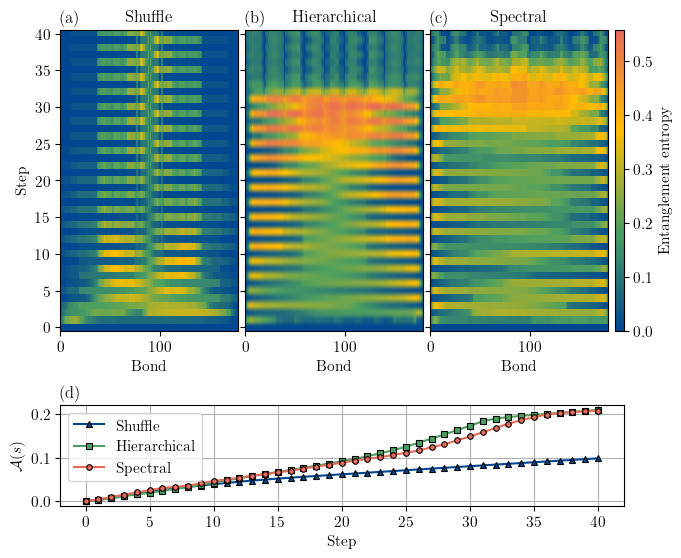

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
import h5py

# =====================
# CUSTOM COLORMAP
# =====================
custom_cycle = ['#004791', "#4DA060", '#FFBE00', "#E86A58"]
custom_cmap = LinearSegmentedColormap.from_list('my_theme', colors=custom_cycle)

# =====================
# CREATE FIG + GRID
# 2 rows, 4 columns
# top row: 3 heatmaps + 1 colorbar
# bottom row: 1 wide plot spanning all 4 columns
# =====================
fig = plt.figure()
gs = gridspec.GridSpec(
    2, 4,
    height_ratios=[3, 1],
    width_ratios=[1, 1, 1, 0.05],   # last column for colorbar
)

axes = [fig.add_subplot(gs[0, i]) for i in range(3)]
cax = fig.add_subplot(gs[0, 3])                    # colorbar axis
ax_bottom = fig.add_subplot(gs[1, :])              # spans all 4 columns

# =====================
# LOAD HEATMAP DATA
# =====================
path_shuffle = "../results/portfolio/MPS_dtau10/ising_Ns10_Nt9_Nq2_K10_gamma1_zeta0.042_rho1.0_triangular_chi128_shuffle/results.h5"
path_default = "../results/portfolio/MPS_dtau10/ising_Ns10_Nt9_Nq2_K10_gamma1_zeta0.042_rho1.0_triangular_chi128_default/results.h5"
path_fiedler = "../results/portfolio/MPS_dtau10/ising_Ns10_Nt9_Nq2_K10_gamma1_zeta0.042_rho1.0_triangular_chi128_fiedler/results.h5"

chi = 128
with h5py.File(path_shuffle, "r") as f:
    ee_vals_shuffle = f["entanglement_entropy"][:] / np.log2(chi)

with h5py.File(path_default, "r") as f:
    ee_vals_default = f["entanglement_entropy"][:] / np.log2(chi)
    samples_default = f["energy_samples"][:]

with h5py.File(path_fiedler, "r") as f:
    ee_vals_fiedler = f["entanglement_entropy"][:] / np.log2(chi)
    samples_fiedler = f["energy_samples"][:]

vmin = min(ee_vals_shuffle.min(), ee_vals_default.min(), ee_vals_fiedler.min())
vmax = max(ee_vals_shuffle.max(), ee_vals_default.max(), ee_vals_fiedler.max())

# =====================
# DRAW HEATMAPS
# =====================
im0 = axes[0].imshow(ee_vals_shuffle.T, aspect='auto', origin='lower',
                     cmap=custom_cmap, vmin=vmin, vmax=vmax)
axes[0].set_title("Shuffle")
axes[0].set_title("(a)", loc='left')
axes[0].set_xlabel("Bond")
axes[0].set_ylabel("Step")

im1 = axes[1].imshow(ee_vals_default.T, aspect='auto', origin='lower',
                     cmap=custom_cmap, vmin=vmin, vmax=vmax)
axes[1].set_title("Hierarchical")
axes[1].set_title("(b)", loc='left')
axes[1].set_xlabel("Bond")
axes[1].set_yticklabels([])

im2 = axes[2].imshow(ee_vals_fiedler.T, aspect='auto', origin='lower',
                     cmap=custom_cmap, vmin=vmin, vmax=vmax)
axes[2].set_title("Spectral")
axes[2].set_title("(c)", loc='left')
axes[2].set_xlabel("Bond")
axes[2].set_yticklabels([])

# =====================
# COLORBAR (dedicated axis, no inset)
# =====================
cbar = fig.colorbar(im2, cax=cax)
cbar.set_label("Entanglement entropy")

# =====================
# BOTTOM PLOT
# =====================
# Shuffle
with h5py.File(path_shuffle, "r") as f:
    ee_vals = f["entanglement_entropy"][:]
ax_bottom.plot(
    np.cumsum(ee_vals.sum(axis=0)) / (179 * np.log2(chi) * 40),
    label="Shuffle", linestyle="-", markeredgecolor="black",
    marker="^", markersize=4, markeredgewidth=.8
)

# Default
with h5py.File(path_default, "r") as f:
    ee_vals = f["entanglement_entropy"][:]
ax_bottom.plot(
    np.cumsum(ee_vals.sum(axis=0)) / (179 * np.log2(chi) * 40),
    label="Hierarchical", linestyle="-", markeredgecolor="black",
    marker="s", markersize=4, markeredgewidth=.8
)

# Fiedler
with h5py.File(path_fiedler, "r") as f:
    ee_vals = f["entanglement_entropy"][:]
ax_bottom.plot(
    np.cumsum(ee_vals.sum(axis=0)) / (179 * np.log2(chi) * 40),
    label="Spectral", linestyle="-", markeredgecolor="black",
    marker="o", markersize=4, markeredgewidth=.8
)

ax_bottom.grid(True)
ax_bottom.set_xlabel("Step")
ax_bottom.set_ylabel(r"$\mathcal{A}(s)$")
ax_bottom.legend()
ax_bottom.set_title("(d)", loc='left')

# =====================
# LAYOUT & SIZE
# =====================
fig.tight_layout(pad=0.1)
fig.set_size_inches(
    set_size(
        width='full',
        fraction=1,
        squeeze_height=2,
        subplots=(2, 3)
    )
)

fig.savefig("paper_figures/combined_plot.pdf", bbox_inches='tight')